<a href="https://colab.research.google.com/github/immanuelobani/Big-Data-Classification-of-Spam-with-Topic-Model-Features/blob/main/22027395_EDA_Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Exploratory data analysis**

In [46]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from gensim import corpora, models
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer


import nltk
nltk.download('stopwords')


# Loads the dataset
df = pd.read_csv("/content/drive/MyDrive/combined_data.csv")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
df.columns

Index(['label', 'text'], dtype='object')

In [49]:
df.columns=['label','text']
df

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
83443,0,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...


In [50]:
print(df.describe)

<bound method NDFrame.describe of        label                                               text
0          1  ounce feather bowl hummingbird opec moment ala...
1          1  wulvob get your medircations online qnb ikud v...
2          0   computer connection from cnn com wednesday es...
3          1  university degree obtain a prosperous future m...
4          0  thanks for all your answers guys i know i shou...
...      ...                                                ...
83443      0  hi given a date how do i get the last date of ...
83444      1  now you can order software on cd or download i...
83445      1  dear valued member canadianpharmacy provides a...
83446      0  subscribe change profile contact us long term ...
83447      1  get the most out of life ! viagra has helped m...

[83448 rows x 2 columns]>


In [51]:
pd.isnull(df).sum()

label    0
text     0
dtype: int64

In [52]:
df.duplicated().sum()

0

In [9]:
df = df.drop_duplicates(keep='first')
df

,spam,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
83443,0,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...


Dimensionality and cardinality of Data

In [53]:
df.shape
print('data has a cardinality size {}' .format(df.shape[0]) +
      ' and dimensionality size {}' .format(df.shape[1]))

data has a cardinality size 83448 and dimensionality size 2


number of distinct observations per group for each column

In [54]:
df.nunique()

label        2
text     83446
dtype: int64

In [55]:
df.select_dtypes(include='object')

,text
0,ounce feather bowl hummingbird opec moment ala...
1,wulvob get your medircations online qnb ikud v...
2,computer connection from cnn com wednesday es...
3,university degree obtain a prosperous future m...
4,thanks for all your answers guys i know i shou...
...,...
83443,hi given a date how do i get the last date of ...
83444,now you can order software on cd or download i...
83445,dear valued member canadianpharmacy provides a...
83446,subscribe change profile contact us long term ...


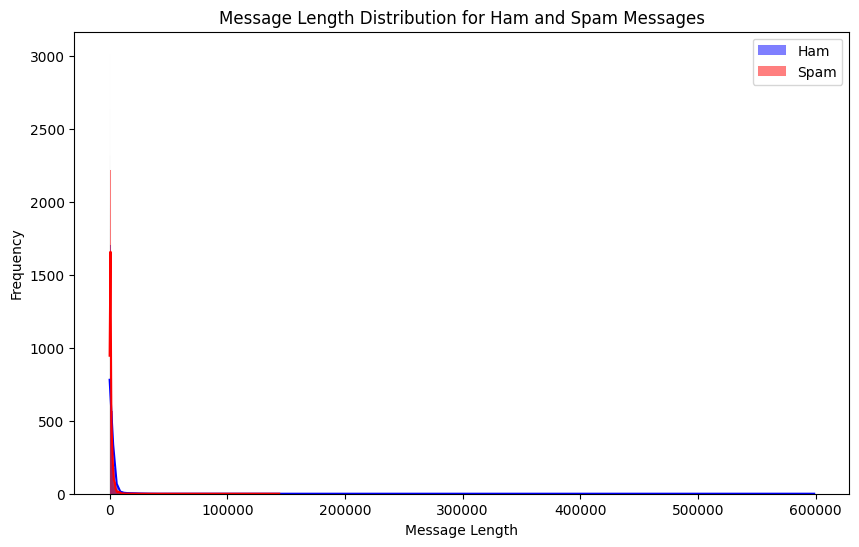

In [57]:
ham_messages = df[df['label'] == 0]['text'].apply(len)
spam_messages = df[df['label'] == 1]['text'].apply(len)

# Plotting histograms
plt.figure(figsize=(10, 6))
sns.histplot(ham_messages, label='Ham', color='blue', alpha=0.5, kde=True)
sns.histplot(spam_messages, label='Spam', color='red', alpha=0.5, kde=True)
plt.title('Message Length Distribution for Ham and Spam Messages')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [58]:
df.dtypes

label     int64
text     object
dtype: object

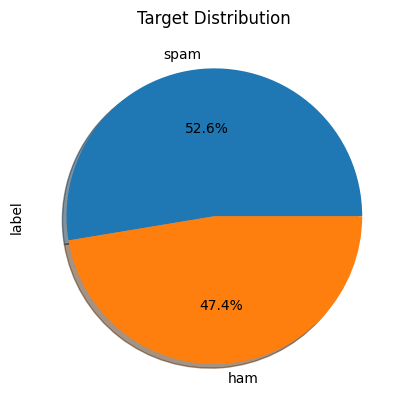

In [60]:
plt.title("Target Distribution")
df["label"].map({0: "ham", 1: "spam"}).value_counts().plot.pie(autopct='%1.1f%%', shadow=True)
plt.show()

word cloud


In [61]:
print(df["text"].unique())

['ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadron heft quell yoghurt bunkmate divert afterimage'
 "wulvob get your medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt have you ever stopped to wonder how much an average man pays for his mediecines ap painkillers drugs to improve the quality of life weight reducing tablets and many more escapenumber what's worse the same mediucine costs a lot more if it is branded rfwur are you intrested so http dmvrwm remunerativ net dfuaeirxygiq visit our website escapenumber"
 " computer connection from cnn com 

In [62]:
from typing import Optional

def generate_word_cloud(
    body: pd.Series,
    stopwords: Optional[set[str]] = STOPWORDS,
    width: int = 800,
    height: int = 800,
    background_color: str = "white",
    min_font_size: int = 10
) -> WordCloud:
    r"""
    Function that takes the bodies of the emails as a parameter and return a word cloud.

    Parameters
    ----------
    body (pd.Series): A pandas Series that contains the bodies of the emails
    stopwords (Optional[set[str]]): An optional set of string that contains the stopwords
    width (int): The width of the generated word cloud image
    height (int): The height of the generated word cloud images
    background_color (str): The background color of the generated word cloud image
    min_font_sizee (int): The minimal font size in the generated word cloud image

    Returns
    -------
    WordCloud
    """

    if stopwords is None:
        stopwords = set()
    words = ""

    # iterate through the csv file
    for val in body:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width=width, height=height,
                    background_color=background_color,
                    stopwords=stopwords,
                    min_font_size=min_font_size).generate(words)
    return wordcloud

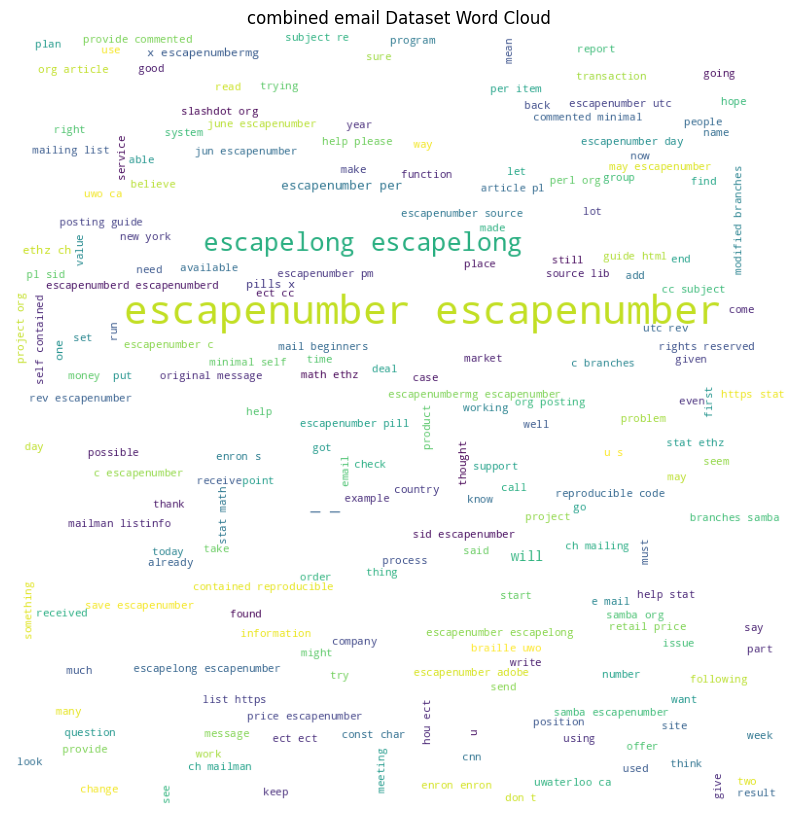

In [63]:
wordcloud = generate_word_cloud(df["text"])

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.title("combined email Dataset Word Cloud")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [64]:
def get_n_words(body: str) -> int: # A function that takes a body (string) as parameter and returns the number of words in the body.


    return len(body.split())

df["n_words"] = df["text"].map(get_n_words)
df.head()

,label,text,n_words
0,1,ounce feather bowl hummingbird opec moment ala...,20
1,1,wulvob get your medircations online qnb ikud v...,103
2,0,computer connection from cnn com wednesday es...,337
3,1,university degree obtain a prosperous future m...,76
4,0,thanks for all your answers guys i know i shou...,222


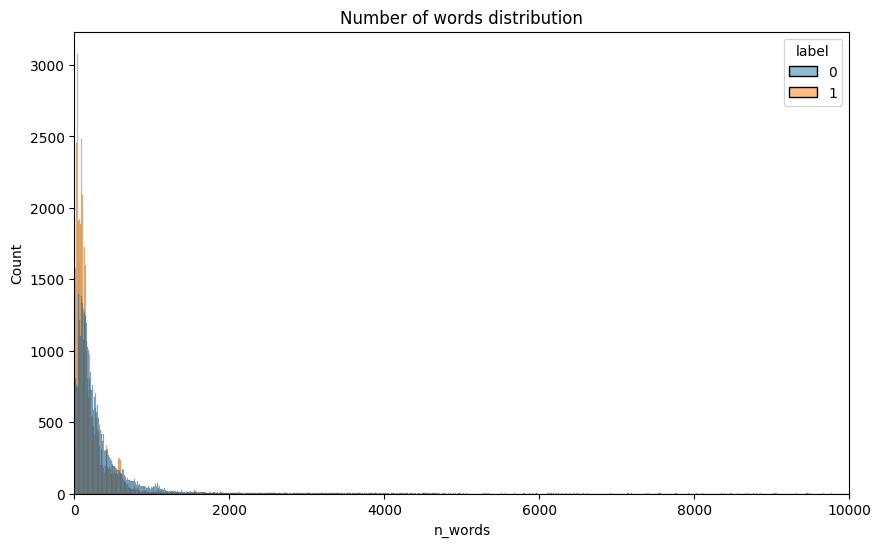

In [66]:
plt.figure(figsize=(10, 6))

max_limit= 10000

# Set the limits of x-axis to improve readability
plt.xlim(0, max_limit)


plt.title("Number of words distribution")
sns.histplot(data=df, x="n_words", hue="label")
plt.show()

In [27]:
df.groupby("spam").describe()

n_words                                                            
        count        mean         std  min    25%    50%    75%       max
spam                                                                     
0     39538.0  365.057944  984.324750  1.0  106.0  200.0  378.0  101984.0
1     43910.0  208.754634  338.269557  1.0   61.0  122.0  249.0   25393.0

**check for similarities between text in spam and ham**

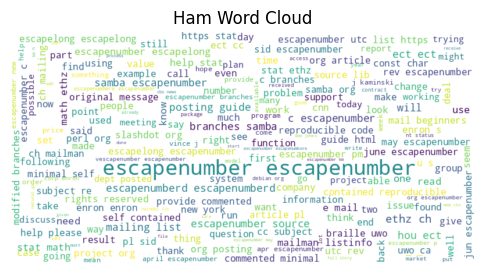

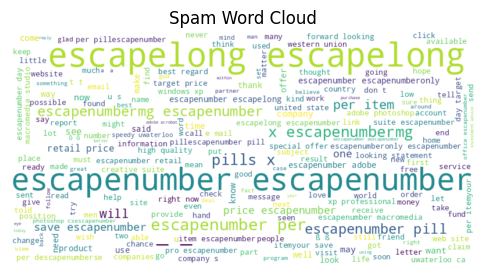

In [37]:
# Remove any rows with empty text
df = df.dropna(subset=['text'])

# Separate ham and spam texts where 0 is ham and 1 is spam
ham_texts = df[df['spam'] == 0]['text']
spam_texts = df[df['spam'] == 1]['text']

# Join ham and spam texts into two strings
all_ham_text = ' '.join(ham_texts)
all_spam_text = ' '.join(spam_texts)

# Check if there is any text to plot a word cloud
if all_ham_text:
    # Generate word cloud for ham
    ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ham_text)

    # Plot the word cloud for ham
    plt.figure(figsize=(6, 6))
    plt.imshow(ham_wordcloud, interpolation='bilinear')
    plt.title('Ham Word Cloud')
    plt.axis('off')
    plt.show()

if all_spam_text:
    # Generate word cloud for spam
    spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_spam_text)

    # Plot the word cloud for spam
    plt.figure(figsize=(6, 6))
    plt.imshow(spam_wordcloud, interpolation='bilinear')
    plt.title('Spam Word Cloud')
    plt.axis('off')
    plt.show()


**statistical summary of dataset**

In [38]:
from collections import Counter


# Statistical details of the dataset
dataset_stats = df.groupby('spam').describe()

# Summary of words present in both spam and ham
ham_texts = df[df['spam'] == 0]['text']
spam_texts = df[df['spam'] == 1]['text']

all_ham_words = ' '.join(ham_texts).split()
all_spam_words = ' '.join(spam_texts).split()

common_words = set(all_ham_words) & set(all_spam_words)

# Count word frequencies for common words in ham and spam
ham_word_freq = Counter(all_ham_words)
spam_word_freq = Counter(all_spam_words)

common_words_freq_in_ham = {word: ham_word_freq[word] for word in common_words}
common_words_freq_in_spam = {word: spam_word_freq[word] for word in common_words}

# Display statistical details of the dataset
print("Statistical details of the dataset:")
print(dataset_stats)

# Display summary of common words and their frequencies
print("\nSummary of common words in both ham and spam:")
print("Word\t\t\tFrequency in Ham\tFrequency in Spam")
for word in common_words:
    print(f"{word.ljust(20)}\t{common_words_freq_in_ham[word]}\t\t\t{common_words_freq_in_spam[word]}")


Streaming output truncated to the last 5000 lines.
pdf                 	1804			110
560                 	39			18
endeavor            	36			89
eeo                 	5			7
illness             	54			73
occasionally        	116			46
organisers          	13			3
lawman              	3			7
archeologist        	4			1
fare                	82			55
strauss             	23			2
tga                 	1			22
partially           	113			23
hierarchal          	1			5
excluding           	128			27
postman             	2			12
presage             	1			5
outtakes            	1			1
evaluative          	2			2
exportable          	2			19
tilted              	7			16
499                 	16			67
censorship          	159			9
562                 	30			9
bitter              	46			157
blix                	1			1
signalled           	15			4
uruguay             	22			11
60                  	663			1478
viven               	7			3
centrino            	9			95
conspirators        	2			3
rumbles             	2			3
testen       

N-gram analysis

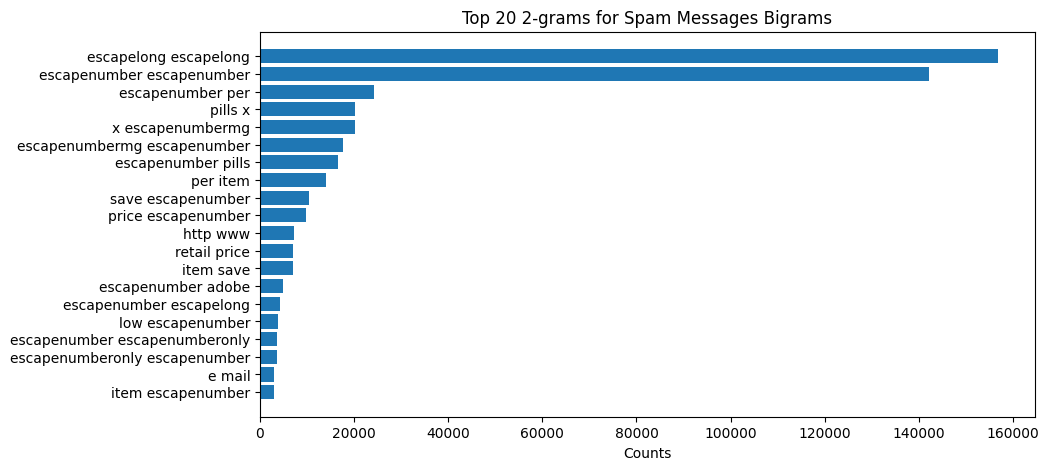

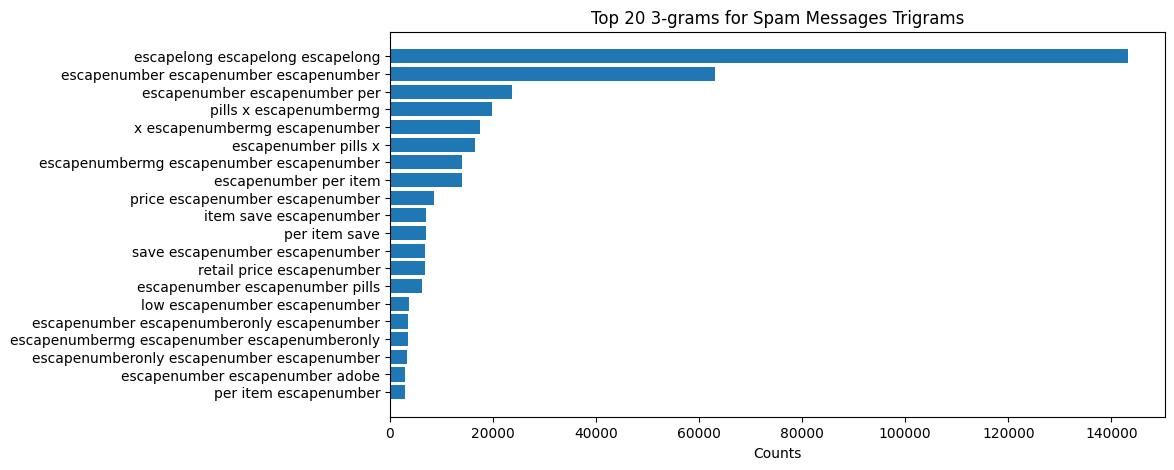

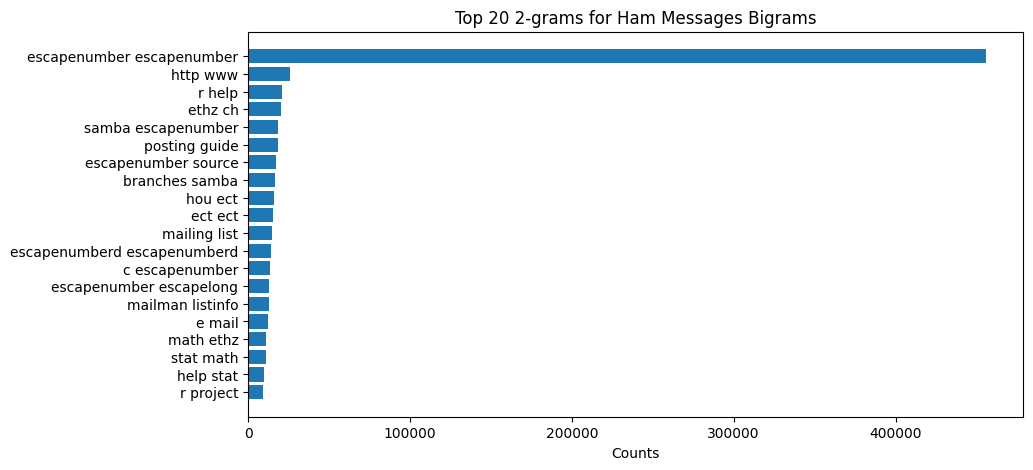

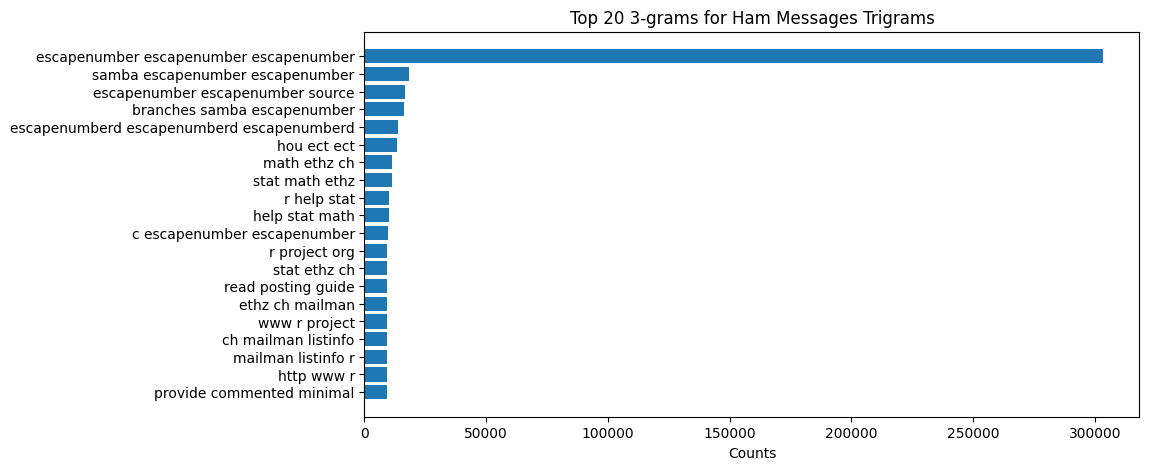

In [82]:
from nltk import ngrams
# Define a function to plot n-grams
def plot_ngrams(ngram_list, n, title):
    # Count the frequency of each n-gram
    ngram_freq = Counter(ngram_list)

    # Get the most common n-grams
    most_common_ngrams = ngram_freq.most_common(20)
    ngrams = [' '.join(gram) for gram, _ in most_common_ngrams]
    counts = [count for _, count in most_common_ngrams]

    # Plot the n-grams
    plt.figure(figsize=(10, 5))
    plt.barh(ngrams, counts)
    plt.xlabel('Counts')
    plt.title(f'Top 20 {n}-grams for {title}')
    plt.gca().invert_yaxis()  # To display the highest count at the top
    plt.show()

# Define a function to clean the text and extract n-grams
def extract_ngrams(data, n):
    ngrams_list = []
    for text in data:
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize the text
        words = word_tokenize(text)
        # Remove stopwords
        words = [word for word in words if word not in stopwords.words('english')]
        # Generate n-grams
        ngrams_list.extend(list(ngrams(words, n)))
    return ngrams_list

# Assuming 'df' is your DataFrame and it contains a 'text' column with your messages
# Extract 2-grams and 3-grams from spam messages
spam_messages = df[df['label'] == 1]['text']
spam_bigrams = extract_ngrams(spam_messages, 2)
spam_trigrams = extract_ngrams(spam_messages, 3)

# Plot the results
plot_ngrams(spam_bigrams, 2, 'Spam Messages Bigrams')
plot_ngrams(spam_trigrams, 3, 'Spam Messages Trigrams')

# Do the same for ham messages if needed
ham_messages = df[df['label'] == 0]['text']
ham_bigrams = extract_ngrams(ham_messages, 2)
ham_trigrams = extract_ngrams(ham_messages, 3)

# Plot the results
plot_ngrams(ham_bigrams, 2, 'Ham Messages Bigrams')
plot_ngrams(ham_trigrams, 3, 'Ham Messages Trigrams')


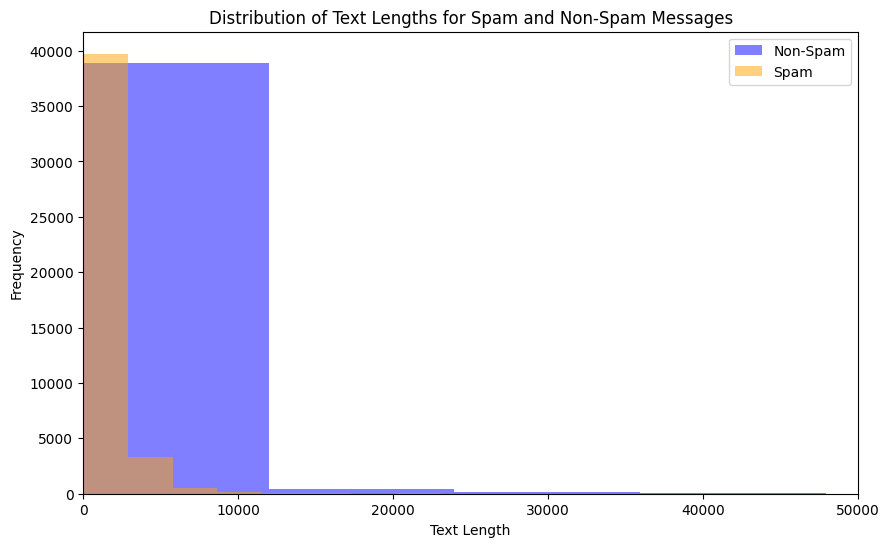

In [43]:
# Calculate the length of each text
df['text_length'] = df['text'].apply(len)

max_limit= 50000

# Create histograms for spam and non-spam messages
plt.figure(figsize=(10, 6))
plt.hist(df[df['spam'] == 0]['text_length'], bins=50, alpha=0.5, label='Non-Spam', color='blue')
plt.hist(df[df['spam'] == 1]['text_length'], bins=50, alpha=0.5, label='Spam', color='orange')

# Set the limits of x-axis to improve readability
plt.xlim(0, max_limit)


plt.title('Distribution of Text Lengths for Spam and Non-Spam Messages')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


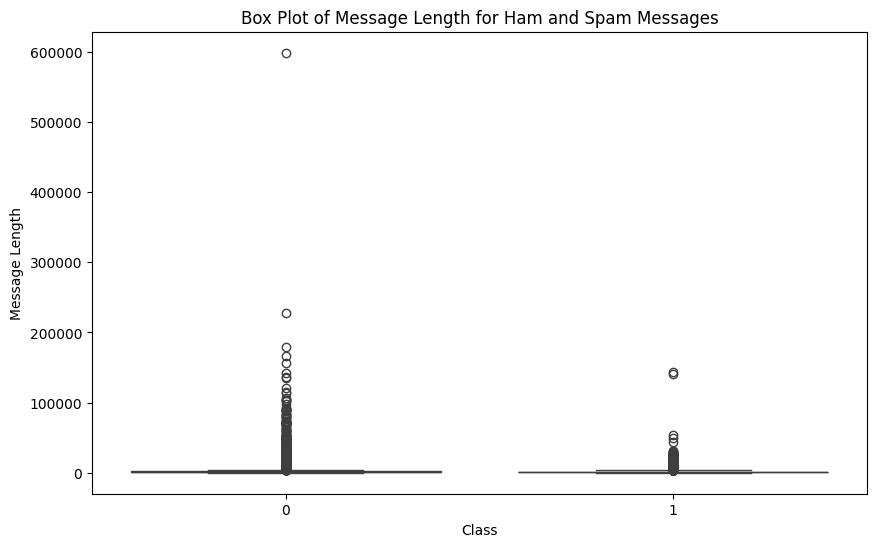

In [72]:
# Create a new column in the dataframe for message length
df['message_length'] = df['text'].apply(len)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the box plot
sns.boxplot(x='label', y='message_length', data=df)

# Set the title and labels of the plot
plt.title('Box Plot of Message Length for Ham and Spam Messages')
plt.xlabel('Class')
plt.ylabel('Message Length')

# Show the plot
plt.show()
